# Housing Rent Price and Venues Data Analysis of Los Angeles

Install required packages :
1. Geopy
2. Folium

In [2]:
# install geopy package 
#!conda install -c conda-forge geopy --yes

# install folium package for visualization in map
!conda install -c conda-forge folium=0.5.0 --yes

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/DSX-Python35

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-2.2.2               |           py35_1         462 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    certifi-2018.8.24          |        py35_1001         139 KB  conda-forge
    ca-certificates-2019.3.9   |       hecc5488_0         146 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    openssl-1.0.2r             |       h14c3975_0         3.1 MB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         4.0 MB

The following NEW packages will

Import all the required libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import folium # # map rendering library
import requests
from sklearn.cluster import KMeans
from sklearn import preprocessing

mpl.style.use('ggplot')
%matplotlib inline

Download the data from https://usc.data.socrata.com/api/views/4a97-v5tx/rows.csv?accessType=DOWNLOAD . This data contains rent price, location coordinates etc from year 2010 to 2016 for every neighborhood in Los Angeles. We will be using the extracting rent price, neighborhood and location coordinates from this file.

In [4]:
!wget -O 'Rent_Price_LA.csv' https://usc.data.socrata.com/api/views/4a97-v5tx/rows.csv?accessType=DOWNLOAD
print('Data Downloaded!')    

--2019-06-04 10:20:51--  https://usc.data.socrata.com/api/views/4a97-v5tx/rows.csv?accessType=DOWNLOAD
Resolving usc.data.socrata.com (usc.data.socrata.com)... 52.206.140.205, 52.206.140.199, 52.206.68.26
Connecting to usc.data.socrata.com (usc.data.socrata.com)|52.206.140.205|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘Rent_Price_LA.csv’

    [     <=>                               ] 4,710,442   4.75MB/s   in 0.9s   

2019-06-04 10:20:53 (4.75 MB/s) - ‘Rent_Price_LA.csv’ saved [4710442]

Data Downloaded!


In [5]:
df_LA = pd.read_csv('Rent_Price_LA.csv')
df_LA.head()

,Policy Area,Dataset,Variable,Year,Amount,Tract,Tract Number,Neighborhood,GEOID,Location,...,layer_0_from_yr99_sgmi,LA Neighborhoods_from_5ikr_59ci,City Boundaries_from_22pk_kkuz,Los Angeles Incorporated Cities,la_county_tracts_from_jczq_z5ui,DPW_CITY_BOUNDARIES_from_dmu2_xaer,:@computed_region_yak3_5aqv,:@computed_region_izm9_hpec,:@computed_region_aysi_wk4g,:@computed_region_an3c_5a9u
0,Housing & Real Estate,Rent Price,Median Rent Price,2010,1236.0,"Census Tract 1247, Los Angeles County, California",124700,Sherman Oaks,1400000US06037124700,"(34.162466912294, -118.413864499994)",...,NaN,NaN,76.0,76.0,742,305,9.0,NaN,742,NaN
1,Housing & Real Estate,Rent Price,Median Rent Price,2010,1483.0,"Census Tract 5038.01, Los Angeles County, Cali...",503801,La Mirada,1400000US06037503801,"(33.899102856233, -117.9936485)",...,146.0,124.0,82.0,82.0,1680,310,14.0,57.0,1680,57.0
2,Housing & Real Estate,Rent Price,Median Rent Price,2010,1086.0,"Census Tract 5739.02, Los Angeles County, Cali...",573902,Long Beach,1400000US06037573902,"(33.8119735, -118.078652493167)",...,10.0,137.0,49.0,49.0,1771,280,5.0,144.0,1771,144.0
3,Housing & Real Estate,Rent Price,Median Rent Price,2010,1231.0,"Census Tract 5766.02, Los Angeles County, Cali...",576602,Long Beach,1400000US06037576602,"(33.765980150191, -118.170779302632)",...,10.0,137.0,49.0,49.0,2139,280,5.0,144.0,2139,144.0
4,Housing & Real Estate,Rent Price,Median Rent Price,2011,1391.0,"Census Tract 1247, Los Angeles County, California",124700,Sherman Oaks,1400000US06037124700,"(34.162466912294, -118.413864499994)",...,NaN,NaN,76.0,76.0,742,305,9.0,NaN,742,NaN


In [6]:
df_LA = df_LA[['Neighborhood', 'Location', 'Amount', 'Year']]


In [7]:
#extracting data only for year 2016 since it is the latest one and then drop rows which have null values in any of the columns.
df_LA = df_LA[df_LA['Year']==2016].dropna(axis=0,how='any').reset_index(drop=True)
df_LA.head(10)

,Neighborhood,Location,Amount,Year
0,La Mirada,"(33.899102856233, -117.9936485)",1861.0,2016
1,Long Beach,"(33.8119735, -118.078652493167)",1224.0,2016
2,Long Beach,"(33.765980150191, -118.170779302632)",1209.0,2016
3,Koreatown,"(34.056107, -118.298204)",900.0,2016
4,Tujunga,"(34.2511895, -118.281014)",1123.0,2016
5,Pacoima,"(34.2400435, -118.404715)",791.0,2016
6,Pacoima,"(34.27316, -118.4202235)",1000.0,2016
7,Northridge,"(34.244559, -118.537408)",1423.0,2016
8,Northridge,"(34.253636, -118.5358265)",2181.0,2016
9,Granada Hills,"(34.263394, -118.4810215)",2107.0,2016


In [8]:
df_LA.rename(columns={'Amount':'Rent($)'}, inplace=True)

In [9]:
#extract latitude and longitude from the location column
df_LA['Latitude'] = df_LA['Location'].apply(lambda x : x.split(',')[0].split('(')[1])
df_LA['Longitude'] = df_LA['Location'].apply(lambda x : x.split(',')[1].split(')')[0])
df_LA.head()

,Neighborhood,Location,Rent($),Year,Latitude,Longitude
0,La Mirada,"(33.899102856233, -117.9936485)",1861.0,2016,33.899102856233,-117.9936485
1,Long Beach,"(33.8119735, -118.078652493167)",1224.0,2016,33.8119735,-118.078652493167
2,Long Beach,"(33.765980150191, -118.170779302632)",1209.0,2016,33.765980150191,-118.170779302632
3,Koreatown,"(34.056107, -118.298204)",900.0,2016,34.056107,-118.298204
4,Tujunga,"(34.2511895, -118.281014)",1123.0,2016,34.2511895,-118.281014


In [10]:
# type conversion
df_LA['Latitude'] = df_LA.Latitude.astype('float')
df_LA['Longitude'] = df_LA.Longitude.astype('float')

In [11]:
df_LA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2296 entries, 0 to 2295
Data columns (total 6 columns):
Neighborhood    2296 non-null object
Location        2296 non-null object
Rent($)         2296 non-null float64
Year            2296 non-null int64
Latitude        2296 non-null float64
Longitude       2296 non-null float64
dtypes: float64(3), int64(1), object(2)
memory usage: 107.7+ KB


In [12]:
#drop column Location and Year
df_LA.drop(['Location', 'Year'], axis=1, inplace=True)

In [13]:
#calculating the mean value of rent and coordinates for each neighborhood since there were one or more for every neighborhood.
df_LA = df_LA.groupby('Neighborhood').mean()
df_LA = df_LA.reset_index()
df_LA

,Neighborhood,Rent($),Latitude,Longitude
0,Acton,1500.000000,34.528856,-118.187391
1,Adams-Normandie,984.200000,34.031700,-118.299543
2,Agoura Hills,2488.000000,34.155796,-118.765359
3,Alhambra,1245.750000,34.084448,-118.135322
4,Alondra Park,1484.000000,33.885925,-118.335435
5,Altadena,1504.375000,34.190096,-118.136334
6,Angeles Crest,1263.000000,34.294753,-117.913563
7,Arcadia,1473.272727,34.128126,-118.037419
8,Arleta,1628.166667,34.242376,-118.432544
9,Arlington Heights,1090.000000,34.045281,-118.320291


In [14]:
df_LA.shape

(257, 4)

#### Use geopy library to get the latitude and longitude values of Los Angeles.

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <i>los_angeles<i>, as shown below.

In [15]:
address = 'Los Angeles, CA'
geolocator = Nominatim(user_agent="los_angeles")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Los Angeles are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Los Angeles are 34.0536909, -118.2427666.


####  Create a map of Toronto with neighborhoods superimposed on top.

In [16]:
LA_map = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, label in zip(df_LA['Latitude'], df_LA['Longitude'], df_LA['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(LA_map)
    
LA_map    

In [17]:
neighborhoods = df_LA
neighborhoods.head()

,Neighborhood,Rent($),Latitude,Longitude
0,Acton,1500.00,34.528856,-118.187391
1,Adams-Normandie,984.20,34.031700,-118.299543
2,Agoura Hills,2488.00,34.155796,-118.765359
3,Alhambra,1245.75,34.084448,-118.135322
4,Alondra Park,1484.00,33.885925,-118.335435


In [18]:
stats = neighborhoods.describe()
stats

,Rent($),Latitude,Longitude
count,257.000000,257.000000,257.000000
mean,1516.090091,34.074370,-118.263162
std,498.798698,0.186936,0.204758
min,625.000000,33.343563,-118.810324
25%,1168.250000,33.974526,-118.393355
50%,1386.222222,34.056733,-118.290768
75%,1725.750000,34.144418,-118.133293
max,3500.000000,34.762262,-117.720671


### Visualization of rent price distribution in different neighborhoods of Los Angeles

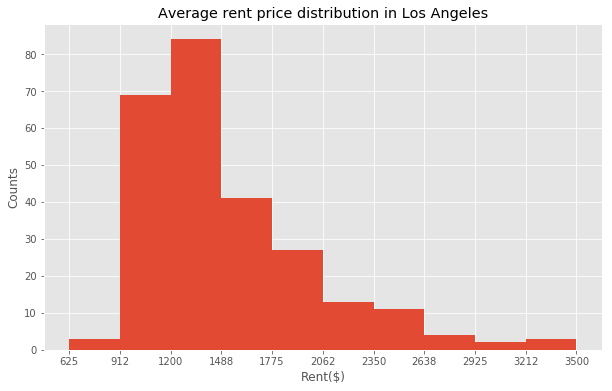

In [19]:
# 'bin_edges' is a list of bin intervals
count, bin_edges = np.histogram(neighborhoods['Rent($)'])

neighborhoods['Rent($)'].plot(kind='hist', figsize=(10,6), xticks=bin_edges)
plt.title('Average rent price distribution in Los Angeles')
plt.xlabel('Rent($)')
plt.ylabel('Counts')
plt.show()


Classification of rent price into three categories : High, Medium, Low

In [20]:
high = stats.loc['75%', 'Rent($)']
low = stats.loc['25%', 'Rent($)'] 
print("High level category : ", high)
print("Low level category : ", low)

High level category :  1725.75
Low level category :  1168.25


Function to decide which category the rent price falls in.

In [21]:
def set_category(price, low, high):
    #print(low , ' ' , high , ' ' , price)
    if price < low :
        return "LOW COST "
    elif price > high:
        return "HIGH COST"
    else:
        return "MEDIUM COST"
    
    

In [22]:
# adding a column for rent category 
for index, row in neighborhoods.iterrows() :
    neighborhoods.loc[index,'Rent Category'] = set_category(row['Rent($)'],low,high)

neighborhoods.head(10)    

,Neighborhood,Rent($),Latitude,Longitude,Rent Category
0,Acton,1500.000000,34.528856,-118.187391,MEDIUM COST
1,Adams-Normandie,984.200000,34.031700,-118.299543,LOW COST
2,Agoura Hills,2488.000000,34.155796,-118.765359,HIGH COST
3,Alhambra,1245.750000,34.084448,-118.135322,MEDIUM COST
4,Alondra Park,1484.000000,33.885925,-118.335435,MEDIUM COST
5,Altadena,1504.375000,34.190096,-118.136334,MEDIUM COST
6,Angeles Crest,1263.000000,34.294753,-117.913563,MEDIUM COST
7,Arcadia,1473.272727,34.128126,-118.037419,MEDIUM COST
8,Arleta,1628.166667,34.242376,-118.432544,MEDIUM COST
9,Arlington Heights,1090.000000,34.045281,-118.320291,LOW COST


In [23]:
# FourSquare API credentials
CLIENT_ID = 'ZVIRVOYFL111YW2MNCBJUDH0D3VFQCL0NBQ4BCWFB3TBT0CE' # your Foursquare ID
CLIENT_SECRET = '5QAVVDTHISB5EO1TYM0KSBYCCHJR1LZQ5T4NOS1FGCFFFFFD' # your Foursquare Secret
VERSION = '20180604' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ZVIRVOYFL111YW2MNCBJUDH0D3VFQCL0NBQ4BCWFB3TBT0CE
CLIENT_SECRET:5QAVVDTHISB5EO1TYM0KSBYCCHJR1LZQ5T4NOS1FGCFFFFFD


## Explore Neighbourhood in Los Angeles

Function to find nearby venues for every neighbourhood in Los Angeles.

In [24]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list = []
    
    for name, lat, lng in zip(names, latitudes, longitudes):
    
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            100)
        
        #make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
    nearby_venues = pd.DataFrame([item for venues in venues_list for item in venues])  
    
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    return(nearby_venues)

In [25]:
LA_venues = getNearbyVenues(neighborhoods['Neighborhood'], 
                                 latitudes = neighborhoods['Latitude'], 
                                 longitudes= neighborhoods['Longitude'])

In [26]:
LA_venues.head(20)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adams-Normandie,34.031700,-118.299543,Orange Door Sushi,34.032270,-118.299541,Sushi Restaurant
1,Adams-Normandie,34.031700,-118.299543,Sushi Delight,34.032445,-118.299525,Sushi Restaurant
2,Adams-Normandie,34.031700,-118.299543,Little Xian,34.032292,-118.299465,Sushi Restaurant
3,Adams-Normandie,34.031700,-118.299543,Tacos La Estrella,34.032230,-118.300757,Taco Place
4,Adams-Normandie,34.031700,-118.299543,Louisiana Fried Chicken,34.032339,-118.301287,Fried Chicken Joint
5,Adams-Normandie,34.031700,-118.299543,El Molino Mexican Delicatessen and Restaurant,34.032636,-118.296582,Food
6,Adams-Normandie,34.031700,-118.299543,Adlong market,34.032242,-118.296229,Grocery Store
7,Adams-Normandie,34.031700,-118.299543,Loren Miller Recreational Park,34.031335,-118.303717,Playground
8,Adams-Normandie,34.031700,-118.299543,Richardson Family Park,34.028221,-118.297457,Park
9,Agoura Hills,34.155796,-118.765359,Morrison Park,34.158015,-118.767216,Park


In [27]:
LA_venues.shape

(3478, 7)

In [52]:
LA_groupby_count = LA_venues.groupby('Neighborhood').count().sort_values('Venue', ascending=False)
LA_groupby_count.head(10)

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Downtown,100,100,100,100,100,100
Beverly Grove,100,100,100,100,100,100
Koreatown,92,92,92,92,92,92
Los Feliz,69,69,69,69,69,69
Hermosa Beach,68,68,68,68,68,68
Chinatown,55,55,55,55,55,55
Gardena,55,55,55,55,55,55
Silver Lake,54,54,54,54,54,54
Venice,54,54,54,54,54,54


### Bar plot visualization for number of venues in top 100 neighborhoods

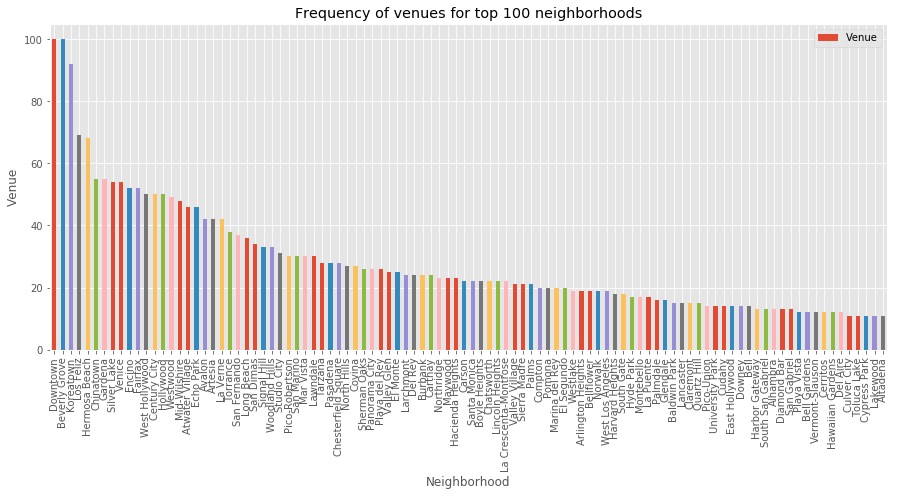

In [48]:
LA_groupby_venue = LA_groupby_count[['Venue']].reset_index().iloc[0:100,:]

LA_groupby_venue.plot(x='Neighborhood', y='Venue', kind='bar', figsize=(15,6))
plt.ylabel('Venue')
plt.title("Frequency of venues for top 100 neighborhoods")
plt.show()

#### Let's find out how many unique categories can be curated from all the returned venues

In [30]:
print("There are {} unique categories of venue".format(len(LA_venues['Venue Category'].unique())))

There are 321 unique categories of venue


## Analyze Each Neighborhood in Los Angeles

In [31]:
# one hot encoding
LA_onehot = pd.get_dummies(LA_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
LA_onehot['Neighborhood'] = LA_venues['Neighborhood']

#move neighborhood to the first column
fixed_columns = [LA_onehot.columns[-1]] + list(LA_onehot.columns[:-1])
LA_onehot = LA_onehot[fixed_columns]
LA_onehot.head(10)

,Neighborhood,ATM,Accessories Store,African Restaurant,Alternative Healer,American Restaurant,Antique Shop,Arcade,Art Gallery,Art Museum,...,Vietnamese Restaurant,Warehouse Store,Watch Shop,Water Park,Weight Loss Center,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Adams-Normandie,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Adams-Normandie,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Adams-Normandie,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Adams-Normandie,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Adams-Normandie,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Adams-Normandie,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,Adams-Normandie,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,Adams-Normandie,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,Adams-Normandie,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,Agoura Hills,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
LA_onehot.shape

(3478, 322)

#### Next, let's group rows by neighborhood and take the mean of the frequency of occurrence of each category

In [33]:
LA_grouped = LA_onehot.groupby('Neighborhood').mean().reset_index()
LA_grouped.head()

,Neighborhood,ATM,Accessories Store,African Restaurant,Alternative Healer,American Restaurant,Antique Shop,Arcade,Art Gallery,Art Museum,...,Vietnamese Restaurant,Warehouse Store,Watch Shop,Water Park,Weight Loss Center,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Adams-Normandie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Agoura Hills,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Alhambra,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Alondra Park,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Altadena,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
LA_grouped.shape

(230, 322)

### Lets put each neighbourhood with top 10 common venues into a pandas dataframe

First, let's write a function to sort the venues in descending order.

In [35]:
def return_top_venues(row,top_venues):
    venues = row[1:]
    sorted_venues = venues.sort_values(ascending=False)
    return sorted_venues.index.values[0:top_venues]

Now, lets create the new dataframe and display the top 10 venues for each neighbourhood

In [36]:
top_venues = 10

suffix = ['st', 'nd',  'rd']

# adding column values for the dataframe
columns = ['Neighborhood']

for i in range(top_venues):
    if i<3:
        columns.append('{}{} most common venue'.format(i+1, suffix[i]))
    else:
        columns.append('{}th most common venue'.format(i+1))    

LA_top_venues = pd.DataFrame(columns = columns)
LA_top_venues['Neighborhood'] = LA_grouped['Neighborhood']
for index in range(LA_grouped.shape[0]):
    LA_top_venues.iloc[index, 1:] = return_top_venues(LA_grouped.iloc[index,:], top_venues)
    
LA_top_venues.head()    
    

,Neighborhood,1st most common venue,2nd most common venue,3rd most common venue,4th most common venue,5th most common venue,6th most common venue,7th most common venue,8th most common venue,9th most common venue,10th most common venue
0,Adams-Normandie,Sushi Restaurant,Food,Fried Chicken Joint,Playground,Taco Place,Park,Grocery Store,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant
1,Agoura Hills,Baseball Field,Park,Yoga Studio,Farmers Market,Electronics Store,Ethiopian Restaurant,Event Space,Fabric Shop,Falafel Restaurant,Farm
2,Alhambra,Convenience Store,Mexican Restaurant,Health & Beauty Service,Fast Food Restaurant,Pet Store,Video Store,Sporting Goods Shop,Electronics Store,Pizza Place,Breakfast Spot
3,Alondra Park,Park,Football Stadium,Yoga Studio,Farmers Market,Electronics Store,Ethiopian Restaurant,Event Space,Fabric Shop,Falafel Restaurant,Farm
4,Altadena,Scenic Lookout,Mexican Restaurant,Breakfast Spot,Smoke Shop,Ice Cream Shop,Campground,Hardware Store,Pharmacy,Dive Bar,Coffee Shop


# Cluster Neighbourhoods

Run k means to cluster the neighbourhoods into 5 clusters

In [37]:
K = 5

LA_grouped_cluster = LA_grouped.drop('Neighborhood', axis=1)
kmeans = KMeans(n_clusters=K, random_state=0).fit(LA_grouped_cluster)

print(kmeans.labels_)    


[3 4 1 4 3 3 3 3 3 3 3 1 1 1 3 1 1 3 0 3 3 3 3 3 3 1 3 3 3 3 4 1 3 3 3 1 3
 3 3 3 3 3 3 3 3 3 1 3 1 3 3 3 3 1 3 3 3 1 3 3 3 3 1 3 3 3 3 3 1 1 3 0 3 3
 3 3 3 3 3 3 3 3 3 1 3 3 3 1 3 3 3 3 3 3 3 3 3 3 3 3 4 3 3 3 3 3 3 3 3 3 1
 1 3 1 3 4 3 3 3 3 0 3 3 0 1 3 3 3 1 3 3 3 0 3 3 3 3 3 3 0 3 3 3 0 3 3 1 3
 3 1 3 3 3 4 1 3 3 4 3 3 1 3 3 3 3 1 1 3 3 1 3 3 3 3 3 3 3 3 3 1 3 3 0 3 4
 0 3 3 1 3 3 3 3 3 1 3 1 3 3 3 3 3 3 2 3 2 3 3 1 3 3 3 3 1 3 3 3 1 3 3 3 3
 3 3 3 4 4 3 1 3]


Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [38]:
LA_top_venues.insert(0, 'Cluster Labels', kmeans.labels_)

LA_merged = neighborhoods

LA_merged = LA_merged.join(LA_top_venues.set_index('Neighborhood'), on='Neighborhood')

LA_merged.head()

,Neighborhood,Rent($),Latitude,Longitude,Rent Category,Cluster Labels,1st most common venue,2nd most common venue,3rd most common venue,4th most common venue,5th most common venue,6th most common venue,7th most common venue,8th most common venue,9th most common venue,10th most common venue
0,Acton,1500.00,34.528856,-118.187391,MEDIUM COST,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Adams-Normandie,984.20,34.031700,-118.299543,LOW COST,3.0,Sushi Restaurant,Food,Fried Chicken Joint,Playground,Taco Place,Park,Grocery Store,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant
2,Agoura Hills,2488.00,34.155796,-118.765359,HIGH COST,4.0,Baseball Field,Park,Yoga Studio,Farmers Market,Electronics Store,Ethiopian Restaurant,Event Space,Fabric Shop,Falafel Restaurant,Farm
3,Alhambra,1245.75,34.084448,-118.135322,MEDIUM COST,1.0,Convenience Store,Mexican Restaurant,Health & Beauty Service,Fast Food Restaurant,Pet Store,Video Store,Sporting Goods Shop,Electronics Store,Pizza Place,Breakfast Spot
4,Alondra Park,1484.00,33.885925,-118.335435,MEDIUM COST,4.0,Park,Football Stadium,Yoga Studio,Farmers Market,Electronics Store,Ethiopian Restaurant,Event Space,Fabric Shop,Falafel Restaurant,Farm


In [39]:
LA_merged.shape

(257, 16)

In [40]:
LA_merged['Rent($)'] = LA_merged['Rent($)'].round(2)

In [41]:
LA_merged = LA_merged[~pd.isnull(LA_merged['Cluster Labels'])]
LA_merged['Cluster Labels'] = LA_merged['Cluster Labels'].astype(int)
LA_merged.head()

,Neighborhood,Rent($),Latitude,Longitude,Rent Category,Cluster Labels,1st most common venue,2nd most common venue,3rd most common venue,4th most common venue,5th most common venue,6th most common venue,7th most common venue,8th most common venue,9th most common venue,10th most common venue
1,Adams-Normandie,984.20,34.031700,-118.299543,LOW COST,3,Sushi Restaurant,Food,Fried Chicken Joint,Playground,Taco Place,Park,Grocery Store,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant
2,Agoura Hills,2488.00,34.155796,-118.765359,HIGH COST,4,Baseball Field,Park,Yoga Studio,Farmers Market,Electronics Store,Ethiopian Restaurant,Event Space,Fabric Shop,Falafel Restaurant,Farm
3,Alhambra,1245.75,34.084448,-118.135322,MEDIUM COST,1,Convenience Store,Mexican Restaurant,Health & Beauty Service,Fast Food Restaurant,Pet Store,Video Store,Sporting Goods Shop,Electronics Store,Pizza Place,Breakfast Spot
4,Alondra Park,1484.00,33.885925,-118.335435,MEDIUM COST,4,Park,Football Stadium,Yoga Studio,Farmers Market,Electronics Store,Ethiopian Restaurant,Event Space,Fabric Shop,Falafel Restaurant,Farm
5,Altadena,1504.38,34.190096,-118.136334,MEDIUM COST,3,Scenic Lookout,Mexican Restaurant,Breakfast Spot,Smoke Shop,Ice Cream Shop,Campground,Hardware Store,Pharmacy,Dive Bar,Coffee Shop


In [42]:
LA_merged['Cluster Labels'].value_counts()

3    171
1     38
4     10
0      9
2      2
Name: Cluster Labels, dtype: int64

### Visualization of neighborhood clusters in a map. The label provides information about the neighborhood, top 3 venues, average rent price in the neighborhood and in which category the rent price falls

In [53]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(K)
ys = [i + x + (i*x)**2 for i in range(K)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []

for lat, lon, name, cluster, price, rent_category, venue1, venue2, venue3 in zip(LA_merged['Latitude'], LA_merged['Longitude'],
                                                                        LA_merged['Neighborhood'],LA_merged['Cluster Labels'], 
                                                                        LA_merged['Rent($)'],LA_merged['Rent Category'],
                                                                        LA_merged.iloc[:,6] , LA_merged.iloc[:,7],
                                                                        LA_merged.iloc[:,8]):
    label = folium.Popup(str(name) + ' | ' + 'Top 3 venues: '
                         + venue1 + ', ' + venue2 + ', ' +
                         venue3 + 
                         ' | ' + 'Rent ' + str(price) + ' | '
                         + rent_category, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters